In [1]:
import pandas as pd 
pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
import os
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import distance  
import re

In [20]:
TEST_CASE = 'T7'
DEVICE = 'DATALIFT'
VOLTAGE = '120'

path = r"../"
test_pre = []
search_str = DEVICE + '_ANSI_C136_50_' + VOLTAGE + 'V_' + TEST_CASE
print(search_str)
with os.scandir(path) as it:
    for entry in it:
        match = re.search(search_str, entry.name)
        if match:
            print(path+entry.name)
            data = pd.read_excel(path+entry.name)
            test_pre.append(data)

DATALIFT_ANSI_C136_50_120V_T7
../20220812_1616_DATALIFT_ANSI_C136_50_120V_T7C1.xls
../20220812_1621_DATALIFT_ANSI_C136_50_120V_T7C2.xls
../20220812_1628_DATALIFT_ANSI_C136_50_120V_T7C3.xls


In [21]:
test_pos = []
for df_condition in test_pre:
    df_raw = pd.DataFrame()
    df_raw['PM s'] = df_condition['PM Sec'] - df_condition['PM Sec'][0]
    df_raw['G4 s'] = df_condition['G4 time stamp [s]'] - df_condition['G4 time stamp [s]'][0]
    df_raw['PM Wh'] = df_condition['PM Whr'] - df_condition['PM Whr'][0]
    df_raw['G4 Wh pre'] = df_condition['G4 active energy [Wh]'] - df_condition['G4 active energy [Wh]'][0]
    df_raw['PM Vrms'] = df_condition['PM Vrms']
    df_raw['PM Arms'] = df_condition['PM Arms']
    df = pd.DataFrame(
        data={
            "G4 Wh": np.interp(df_raw['PM s'], df_raw['G4 s'], df_raw['G4 Wh pre']),
            "G4 Vrms": np.interp(df_raw['PM s'], df_raw['G4 s'], df_condition['G4 voltage [V]']),
            "G4 Arms": np.interp(df_raw['PM s'], df_raw['G4 s'], df_condition['G4 current [A]'])
        }
    )
    df_raw = pd.concat([df_raw, df], axis=1)

    df_raw["Error"] = 100*(df_raw["G4 Wh"]-df_raw['PM Wh'])/df_raw['PM Wh']
    df_raw["Voltage_Error"] = 100*(df_raw["G4 Vrms"]-df_raw['PM Vrms'])/df_raw['PM Vrms']
    df_raw["Current_Error"] = 100*(df_raw["G4 Arms"]-df_raw['PM Arms'])/df_raw['PM Arms']
    # print(f'Max Raw Error: {df_raw["Error"].abs().max()}')
    df_raw = df_raw.drop(0)
    test_pos.append(df_raw)

error_class = 0.5/100

df_limits = pd.DataFrame()
df_limits['Max_Class_Error'] = 100*error_class*np.ones(len(test_pos[0]['PM s']))
df_limits['Min_Class_Error'] = -100*error_class*np.ones(len(test_pos[0]['PM s']))

# C1
dfc = test_pos[0]
print(f'C1 - Measurement: {dfc["G4 Wh"][10]} Wh')
print(f'C1 - Reference: {dfc["PM Wh"][10]} Wh')
reference = 100*(dfc['G4 Wh'][10]-dfc['PM Wh'][10])/dfc['PM Wh'][10]
print(reference)
if (abs(reference) > 100*error_class):
    print('C1 FAILED')
else:
    print('C1 PASSED')
max_dev = 0.2/100
print(reference+100*max_dev)
print(reference-100*max_dev)
print(f'C1 - Reference Error: {(100+reference):1.2f} %')
print(f'C1 - Upper Error: {(100+reference+100*max_dev):1.2f} %')
print(f'C1 - Lower Error: {(100+reference-100*max_dev):1.2f} %')
df_limits['C1 - Max_Error'] = (reference+100*max_dev)*np.ones(len(test_pos[0]['PM s']))
df_limits['C1 - Min_Error'] = (reference-100*max_dev)*np.ones(len(test_pos[0]['PM s']))

# C4
# dfc = test_pos[3]
# print(f'\nC4 - Measurement: {dfc["G4 Wh"][10]} Wh')
# print(f'C4 - Reference: {dfc["PM Wh"][10]} Wh')
# reference = 100*(dfc['G4 Wh'][10]-dfc['PM Wh'][10])/dfc['PM Wh'][10]
# print(reference)
# if (abs(reference) > 100*error_class):
#     print('C4 FAILED')
# else:
#     print('C4 PASSED')
# max_dev = 0.2/100
# print(reference+100*max_dev)
# print(reference-100*max_dev)
# print(f'C4 - Reference Error: {(100+reference):1.2f} %')
# print(f'C4 - Upper Error: {(100+reference+100*max_dev):1.2f} %')
# print(f'C4 - Lower Error: {(100+reference-100*max_dev):1.2f} %')
# df_limits['C4 - Max_Error'] = (reference+100*max_dev)*np.ones(len(test_pos[0]['PM s']))
# df_limits['C4 - Min_Error'] = (reference-100*max_dev)*np.ones(len(test_pos[0]['PM s']))

C1 - Measurement: 10.34134305822875 Wh
C1 - Reference: 10.341809999999999 Wh
-0.00451508750643109
C1 PASSED
0.19548491249356892
-0.2045150875064311
C1 - Reference Error: 100.00 %
C1 - Upper Error: 100.20 %
C1 - Lower Error: 99.80 %


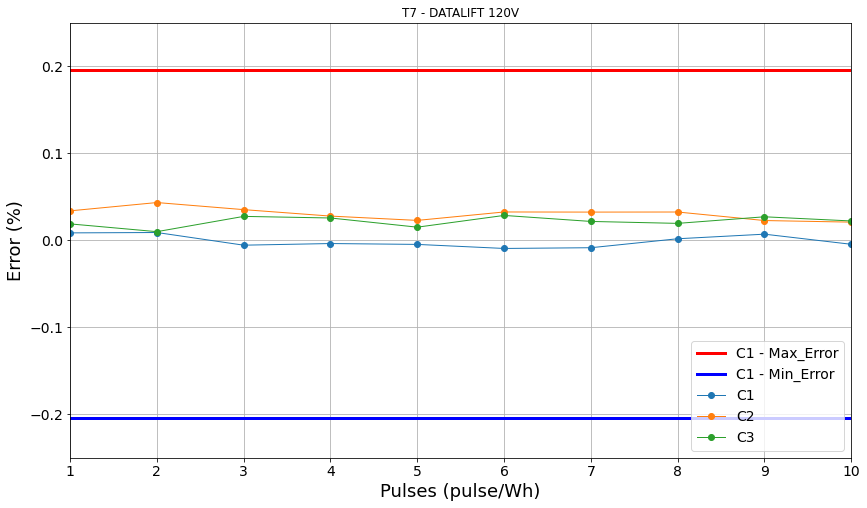

In [24]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)
ax = plt.gca()

sizeh = 14
sizev = 8

df_limits.plot(y='C1 - Max_Error', ax=ax, figsize=(sizeh, sizev), label="C1 - Max_Error", linewidth=3, color='red')
df_limits.plot(y='C1 - Min_Error', ax=ax, figsize=(sizeh, sizev), label="C1 - Min_Error", linewidth=3, color='blue')

for index, df_raw in enumerate(test_pos):
    if index == 0 or index == 1 or index == 2:
        df_raw.plot(y='Error', ax=ax, figsize=(sizeh, sizev), label=f'C{index+1}', linewidth=1, marker='o')
        ax.set_xlabel("Pulses (pulse/Wh)", fontsize=18)
        ax.set_ylabel("Error (%)", fontsize=18)
        plt.axis((1, 10, -0.25, 0.25))
        plt.legend(loc=4, fontsize = 14)
        plt.title(f'{TEST_CASE} - {DEVICE} {VOLTAGE}V')
        plt.grid(True)

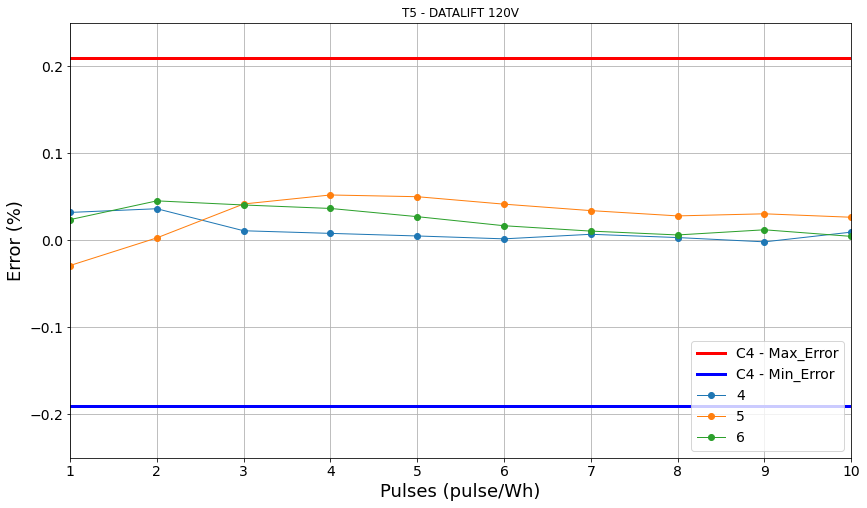

In [6]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)
ax = plt.gca()

df_limits.plot(y='C4 - Max_Error', ax=ax, figsize=(sizeh, sizev), label="C4 - Max_Error", linewidth=3, color='red')
df_limits.plot(y='C4 - Min_Error', ax=ax, figsize=(sizeh, sizev), label="C4 - Min_Error", linewidth=3, color='blue')

for index, df_raw in enumerate(test_pos):
    if index == 3 or index == 4 or index == 5:
        df_raw.plot(y='Error', ax=ax, figsize=(sizeh, sizev), label=index+1, linewidth=1, marker='o')
        ax.set_xlabel("Pulses (pulse/Wh)", fontsize=18)
        ax.set_ylabel("Error (%)", fontsize=18)
        plt.axis((1, 10, -0.25, 0.25))
        plt.legend(loc=4, fontsize = 14)
        plt.title(f'{TEST_CASE} - {DEVICE} {VOLTAGE}V')
        plt.grid(True)

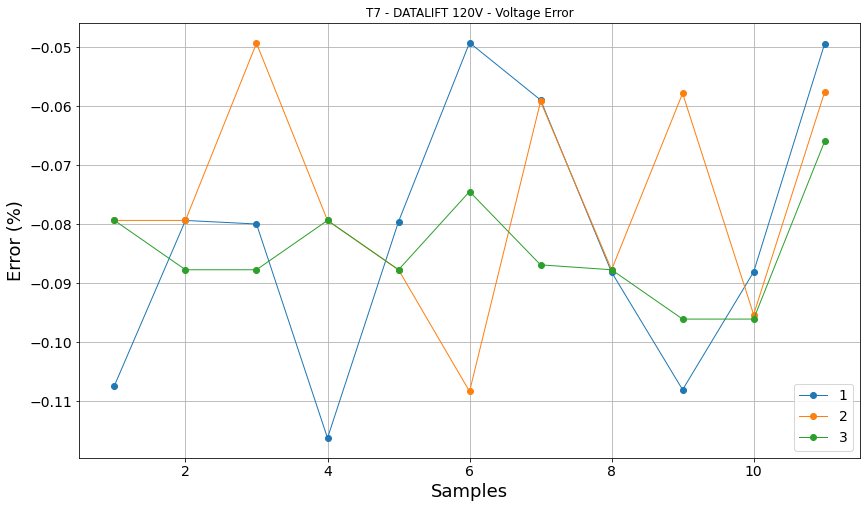

In [25]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)
ax = plt.gca()

for index, df_raw in enumerate(test_pos):
    df_raw.plot(y='Voltage_Error', ax=ax, figsize=(sizeh, sizev), label=index+1, linewidth=1, marker='o')
    ax.set_xlabel("Samples", fontsize=18)
    ax.set_ylabel("Error (%)", fontsize=18)
    # plt.axis((1, 10, -0.1, 0.25))
    plt.legend(loc=4, fontsize = 14)
    plt.title(F'{TEST_CASE} - {DEVICE} {VOLTAGE}V - Voltage Error')
    plt.grid(True)

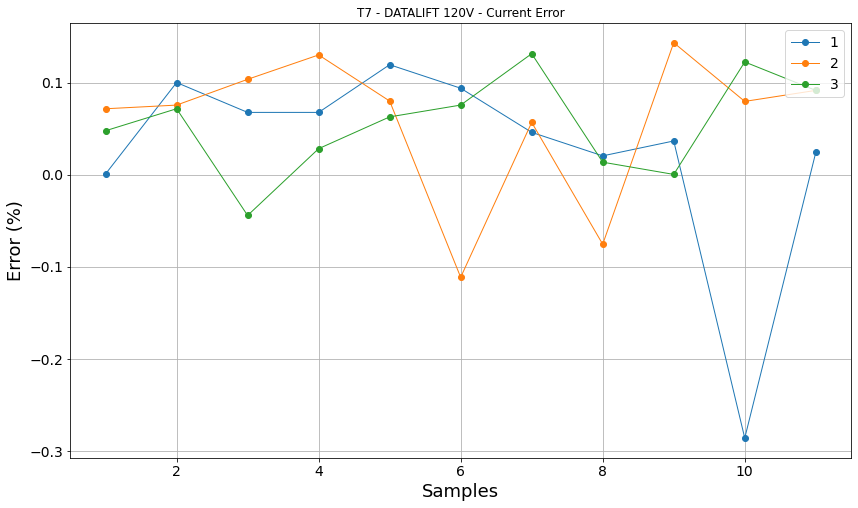

In [26]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)
ax = plt.gca()

for index, df_raw in enumerate(test_pos):
    df_raw.plot(y='Current_Error', ax=ax, figsize=(sizeh, sizev), label=index+1, linewidth=1, marker='o')
    ax.set_xlabel("Samples", fontsize=18)
    ax.set_ylabel("Error (%)", fontsize=18)
    # plt.axis((1, 10, -7, 5))
    plt.legend(loc=1, fontsize = 14)
    plt.title(F'{TEST_CASE} - {DEVICE} {VOLTAGE}V - Current Error')
    plt.grid(True)